<a href="https://colab.research.google.com/github/javierortuno1/pytorch-step-by-step/blob/main/Chapter03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide - A simple classification problem

# Chapter 3

We are trying to predict which class a data point belongs to

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter3()
# This is needed to render the plots in this chapter
from plots.chapter3 import *

Finished!


In [2]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

from stepbystep.v0 import StepByStep

# A Simple Classification Problem

Two features where the label (y) are represented by the color blue or red. Therefore we have assign numeric values to them. Such as assigning zero to red and one to blue.

the class associated with zero is the negative class, while one corresponds to the positive class

Color | Value | Class
* Red   | 0     | Negative
* Blue  | 1     | Possitive


In a classification model, the output is the predicted probability of the possitive class (in this case; Our model will predict the probability of a point being blue)

If the model is the other way arround it does not matter since both probabilities add up to one, we could esaily convert between them, so the models are equivalent

## Data Generation



In [3]:
# make_moons always creates a dataset with exactly two features.
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)    # The noise here prevents perfect separation, since Adding noise creates overlapping regions between classes, making the classification problem more realistic and challenging
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

print(f'X.shape: {X.shape}')        # (100, 2) 2D 100 samples and each sample has 2 features
print(f'y.shape: {y.shape}')        # (100,) 1D  100 samples where each element represents the class label (0 or 1) corresponding to each data point in X
print(f'X_train.shape: {X_train.shape}')    # (80, 2) 2D
print(f'y_train.shape: {y_train.shape}')    # (80,) 1D

X.shape: (100, 2)
y.shape: (100,)
X_train.shape: (80, 2)
y_train.shape: (80,)


Original data:

* X₁: spans from -1.32 to 2.18 (range of about 3.5 units)
* X₂: spans from -1.04 to 1.57 (range of about 2.6 units)

After standardization:

- Both features now span roughly -2 to +2 standard deviations
- More balanced ranges: X₁ (-2.01 to 1.91) and X₂ (-1.81 to 2.18)
- Both features now contribute more equally to the model since they're on the same scale

This transformation preserves the moon shapes but rescales them to have comparable ranges centered around zer

In [4]:
print("Original ranges:")
print(f"X1 range: {X[:, 0].min():.2f} to {X[:, 0].max():.2f}")
print(f"X2 range: {X[:, 1].min():.2f} to {X[:, 1].max():.2f}")
# standardization ensures both features contribute equally to the model's decision boundary.
# Without standardization, if X₁ ranges from 0-1 while X₂ ranges from 0-1000, X₂ would dominate the model's decisions.
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)
print("After standardization:")
print(f"X1 range: {X_train[:, 0].min():.2f} to {X_train[:, 0].max():.2f}")
print(f"X2 range: {X_train[:, 1].min():.2f} to {X_train[:, 1].max():.2f}")

Original ranges:
X1 range: -1.32 to 2.18
X2 range: -1.04 to 1.57
After standardization:
X1 range: -2.01 to 1.91
X2 range: -1.81 to 2.18


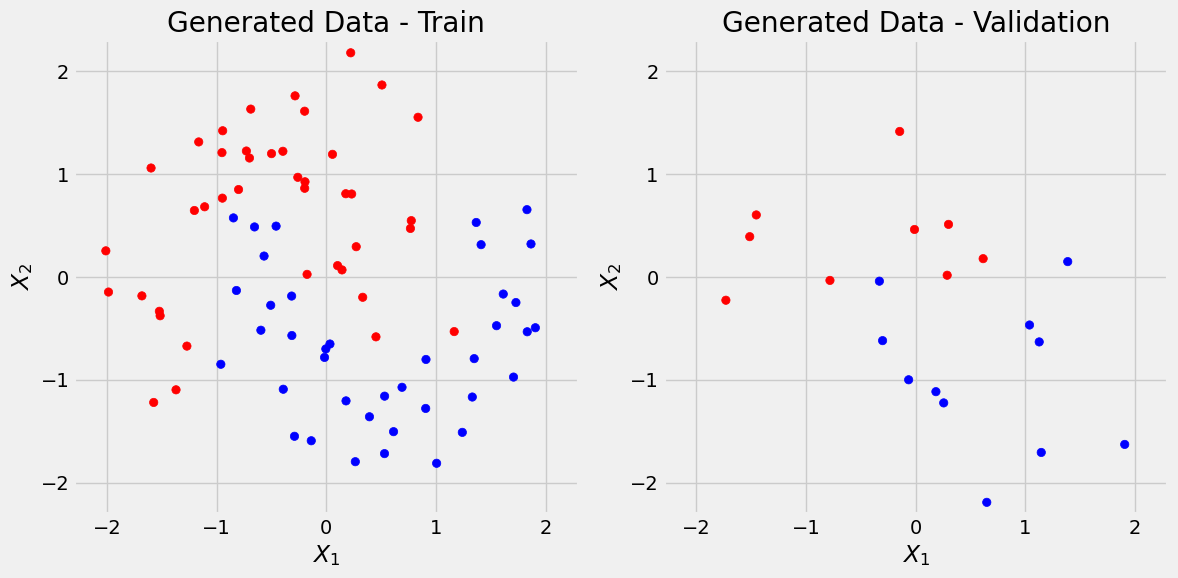

In [23]:
fig = figure1(X_train, y_train, X_val, y_val)

## Data Preparation

In [5]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()                   # 2D
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()    # 1D -> 2D
print(x_train_tensor.shape, y_train_tensor.shape)

x_val_tensor = torch.as_tensor(X_val).float()                     # 2D
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()      # 1D -> 2D

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set  - Mini-batches
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

torch.Size([80, 2]) torch.Size([80, 1])


## Model

Giving a classification problem, one of the more straightforward models is the logistic regression

**Linear Regression**:

- Predicts continuous numerical values (e.g., price, temperature)
- Output can be any real number
- Uses direct linear equation: y = b + w₁x₁ + w₂x₂

**Logistic Regression**:

- Predicts probabilities for classification (0 to 1)
- Uses sigmoid function to transform linear output into probability
- Equation: P(y=1) = sigmoid(b + w₁x₁ + w₂x₂)
- Used for binary classification problems (like the moons dataset)

The key difference is the sigmoid transformation in logistic regression that bounds output between 0 and 1 for classification tasks.

Let's start with th elinear regression model

$$
\Large
y = b + w_1x_1 + w_2x_2 + \epsilon
$$

There is one problem here: Our lables (y) are discrete (blue or red, 0 or 1), no other value is allowed.

Then we need to change the model slightly to adapt it to our purposes

What if we assign the positive outputs to one and the negative outputs to zero? We're aleady calling them positive and negative classes anyway, right?

$$
\Large
y =
\begin{cases}
1,\ \text{if }b + w_1x_1 + w_2x_2 \ge 0
\\
0,\ \text{if }b + w_1x_1 + w_2x_2 < 0
\end{cases}
$$

### Logits

Then let's give the right-hand side of the equation above a name: logit(z)

$$
\Large
z = b + w_1x_1 + w_2x_2
$$

It's similar to the original linear regression (Continues values as outputs) model, but we're calling the resulting value (z), or logit, instead of y or label.

And since the linear regression needs an error term (epsilon for the uncertanty), then in a logit the uncertanty comes from the probability; Instead of assigning a data point to a discrete label (zero or one), we'll compute the probability of a data point's belonging to the positive class

### Probabilities

$$
\Large
\begin{aligned}
& \text{P}(y=1) \approx 1.0, & \text{if } &z \gg 0
\\
& \text{P}(y=1) = 0.5, & \text{if } &z = 0
\\
& \text{P}(y=1) \approx 0.0, & \text{if } &z \ll 0
\end{aligned}
$$

We still need to figure out a function that maps logit values (z) into probabilties

### Odds Ratio - What a re the odds?

The ratio between probability of success (p) and the probability of failure (q)

$$
\Large \text{odds ratio }(p) = \frac{p}{q} = \frac{p}{1-p}
$$

In [15]:
def odds_ratio(prob):
    return prob / (1 - prob)

In [16]:
p = .75
q = 1 - p
odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

In [ ]:
fig = figure2(p)

The red dots correspond to the probabilities of 25% (q), 50% and 75% (p).

Clearly in the left plot they are not symetrical. We need something symetrical for mapping the logits values into probabilities.

If the functions weren't symetrical different choices for the possitive class (choosing 1 as red and 0 as blue) would produce models that were not equivalent

### Log Odds Ratio

Logarithm of the odds ratio, the function is not only symmetrical, but also maps probabilities into real numbers, instead of only the positive ones

$$
\Large \text{log odds ratio }(p) = \text{log}\left(\frac{p}{1-p}\right)
$$

In [18]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

p = .75
q = 1 - p
log_odds_ratio(p), log_odds_ratio(q)

(1.0986122886681098, -1.0986122886681098)

In [ ]:
fig = figure3(p)

On the left, each proabability maps into a log odds ratio and the red dots correspond to probabilities of 25%, 50% and 75%

and by fliping the horizontal and vertical axes (right) plot, we are inverting the function, thus mapping each log odds ratio into a probability. That's the function we were looking for!

### From Logits to Probabilities

$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$

Let's try to isolate p:

$$
\Large
\begin{aligned}
\frac{1}{e^z}& = \frac{1-p}{p}
\\
e^{-z}& = \frac{1}{p} - 1
\\
1 + e^{-z}& = \frac{1}{p}&
\\
p& = \frac{1}{1 + e^{-z}}
\end{aligned}
$$

and this isolation of p is the sigmoid function!!

$$
\Large
p = \sigma(z) = \frac{1}{1+e^{-z}}
$$

In [20]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = .75
q = 1 - p
sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(0.75, 0.25)

### Sigmoid

two ways:

- torch.sigmoid() as a function
- nn.Sigmoid as a model

Why a model? -> Remember, models can be used as layers of another, larger model. That's exactly what we're going to do with the sigmoid class.


In [21]:
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

In [ ]:
fig = figure4(p)

### Logistic Regression

then, givent two features, x1 and x2, the model will fit a linear regression such that its outputs are logits (z), which are then converted into probabilitites using a sigmoid function

$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2)
$$

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/logistic_model.png?raw=1)

Activation function such as sigmoid where used to map logits into probability but also for making decisions

The term "activation function" comes from its analogy to biological neurons. Just as biological neurons either "fire" (activate) or don't based on input signals reaching a threshold, artificial neurons use activation functions to determine their output signal strength. The name reflects this biological inspiration, though the actual function is mathematical - transforming input signals into output values that determine how strongly the artificial neuron "fires" or "activates".

During training, neurons' activation patterns change as weights and biases are adjusted. A neuron that initially fires strongly for certain inputs might eventually become less active or inactive for those same inputs as the network learns better feature representations.

This is part of how neural networks learn to specialize - some neurons become selective for specific patterns while others may become less relevant. The final activation pattern of neurons reflects what the network has learned is most useful for the task.

In the binary classification example from the code, the sigmoid activation helps determine the final class probability, and the weights/biases are adjusted during training to make this probability more accurate.

### A Note on Notation

The vectorized representations of the weights (W) and fetures (X) are

$$
\Large W =
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X =
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
$$

$$
\Large
\begin{aligned}
z
& = W^T X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}
$$

In [6]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1)
print(model1.state_dict())

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


## Loss

The appropiate loss for a classification problem is the Binary Cross-Entropy (BCE) Loss, sometimes known as log loss



$$
\Large y_i = 1 \Rightarrow \text{error}_i=\text{log}(\text{P}(y_i=1))
$$

$$
\Large \text{P}(y_i=0)=1-\text{P}(y_i=1)
$$

$$
\Large y_i = 0 \Rightarrow \text{error}_i=\text{log}(1-\text{P}(y_i=1))
$$

$$
\Large
\text{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$

In [25]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2]) # 90% of being positive for actual positive label and 20% of being positive for actual negative label

# Positive class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()
# Negative class (labels == 0)
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()
# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)

loss = -(first_summation + second_summation) / n_total
loss

tensor(0.1643)

$$
\Large
\text{BCE}(y)={-\frac{1}{N}\sum_{i=1}^{N}{\left[y_i \text{log}(\text{P}(y_i=1)) + (1-y_i) \text{log}(1-\text{P}(y_i=1))\right]}}
$$

In [26]:
summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) +
    (1 - dummy_labels) * torch.log(1 - dummy_predictions)
)
loss = -summation / n_total
loss

tensor(0.1643)

### BCELoss

It takes probabilities as arguments

In [27]:
loss_fn = nn.BCELoss(reduction='mean')  # Since BCELoss is a higher-function; it retunrs another function that is the actual loss function, which will take
                                        # both predictions and labels to compute the loss

loss_fn

BCELoss()

In [28]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# RIGHT
right_loss = loss_fn(dummy_predictions, dummy_labels)

# WRONG
wrong_loss = loss_fn(dummy_labels, dummy_predictions)

print(right_loss, wrong_loss)

tensor(0.1643) tensor(15.0000)


### BCEWithLogitsLoss

It takes logits as arguments, meaning that we do not need the sigmoid as the layer if my model when using this loss function

In [29]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')

loss_fn_logits

BCEWithLogitsLoss()

In [30]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])

print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


In [31]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor(0.1643)

### Imbalanced Dataset

In [32]:
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

$$
\Large \text{pos_weight} = \frac{\text{# points in negative class}}{\text{# points in positive class}}
$$

In [33]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()

pos_weight = (n_neg / n_pos).view(1,)
pos_weight

tensor([3.])

In [34]:
loss_fn_imb = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)

In [35]:
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss

tensor(0.2464)

$$
\Large \text{weighted average} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{\text{pos_weight} N_{\text{pos}}+N_{\text{neg}}}
$$

$$
\Large \text{BCEWithLogitsLoss} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{N_{\text{pos}}+N_{\text{neg}}}
$$

In [36]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight)

loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)

loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([0.1643])

## Model Configuration

In [7]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

## Model Training

In [ ]:
!cat stepbystep/v0.py

In [8]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

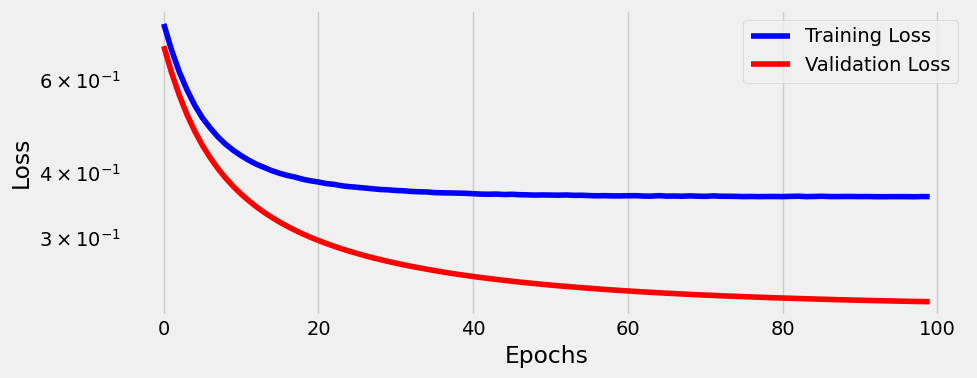

In [40]:
fig = sbs.plot_losses()

In [42]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]])), ('linear.bias', tensor([-0.0591]))])


those are the logits states

$$
\large
\begin{array}{ccccccc}
z & = & b & + & w_1x_1 & + & w_2x_2
\\
z & = & -0.0587 & + & 1.1822x_1 & - & 1.8684x_2
\end{array}
$$

#### Making Predictions (Logits)

In [43]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.20345592],
       [ 2.9444451 ],
       [ 3.6933177 ],
       [-1.2334073 ]], dtype=float32)

#### Making Predictions (Probabilities)

In [44]:
probabilities = sigmoid(predictions)
probabilities

array([[0.5506892 ],
       [0.9500003 ],
       [0.9757152 ],
       [0.22558564]], dtype=float32)

#### Making Predictions (Classes)

Going from probabilities to classes

$$
\Large y =
\begin{cases}
1,\ \text{if P}(y=1) \ge 0.5
\\
0,\ \text{if P}(y=1) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } \sigma(z) \ge 0.5
\\
0,\ \text{if } \sigma(z) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
$$

In [45]:
classes = (predictions >= 0).astype(int)
classes

array([[1],
       [1],
       [1],
       [0]])

## Decision Boundary

$$
\Large
\begin{array}{ccccccccc}
z & = &   0 & =   & b & + & w_1x_1 & + & w_2x_2
\\
& & -w_2x_2 & = & b & + & w_1x_1 & &
\\
& & x_2 & = & -\frac{b}{w_2} & - &\frac{w_1}{w_2}x_1 & &
\end{array}
$$

$$
\Large
\begin{array}{ccccccccc}
& & x_2 & = & -\frac{0.0587}{1.8684} & + &\frac{1.1822}{1.8684}x_1 & &
\\
& & x_2 & = & -0.0314 & + &0.6327x_1 & &
\end{array}
$$

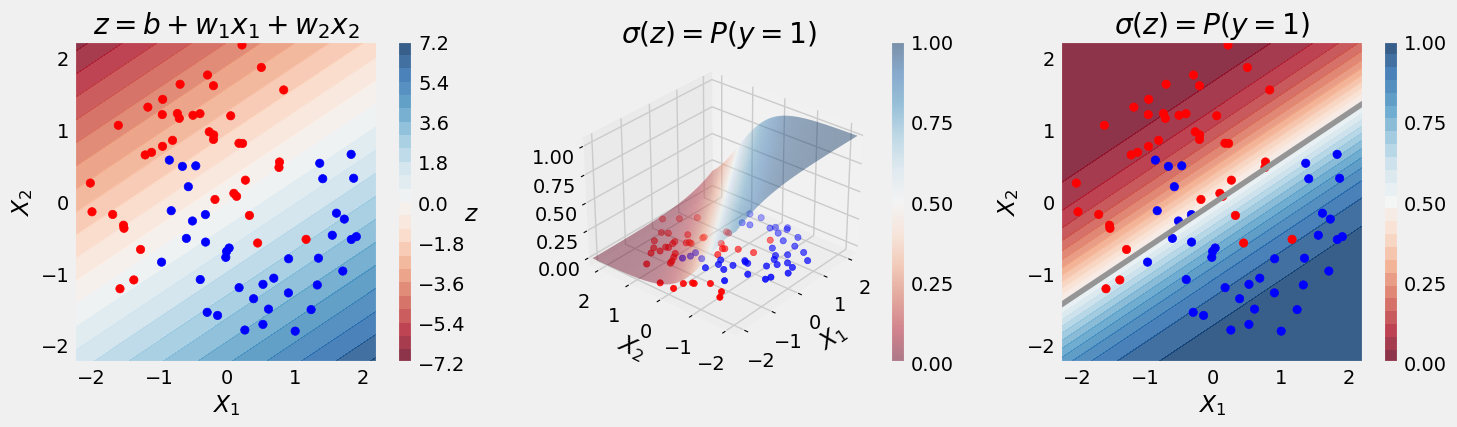

In [46]:
# Training set
fig = figure7(X_train, y_train, sbs.model, sbs.device)

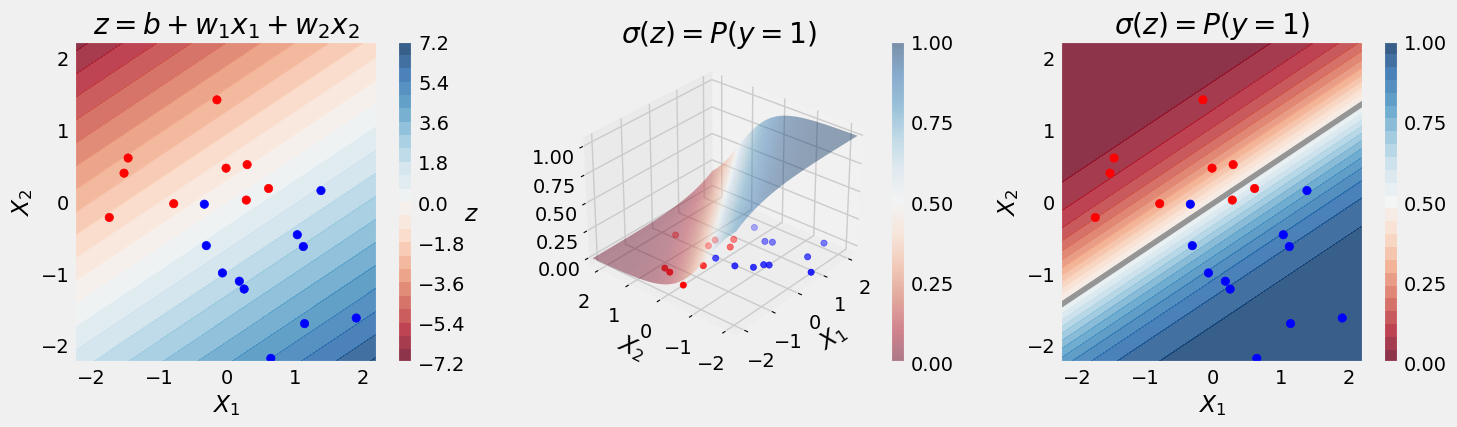

In [47]:
# Validation set
fig = figure7(X_val, y_val, sbs.model, sbs.device)

### Are my data points separable?

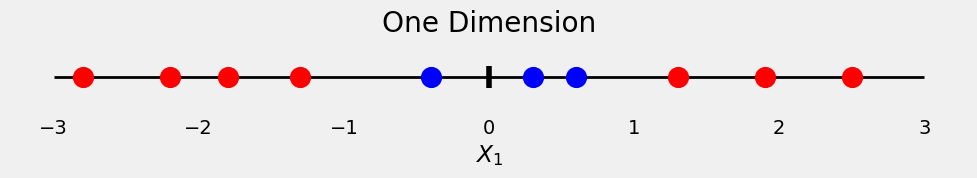

In [10]:
x = np.array([-2.8, -2.2, -1.8, -1.3, -.4, 0.3, 0.6, 1.3, 1.9, 2.5])
y = np.array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

fig = one_dimension(x, y)

If we cannot separate the data in one dimension we will try to do it in other dimentions

By apllying a function to the original dimension and the result of te function as a second dimension
$$
\Large X_2 = f(X_1)= X_1^2
$$


The more dimensions (features or attributes that we want to pay attention of the data), the more separable the points are

The idea is: As the number of dimensions increases, there is more and more empty space. If the data points are farther apart, it is likely easier to separate them.

Therefore it is the famous kernel trick that is about adding a function to create additional dimensions



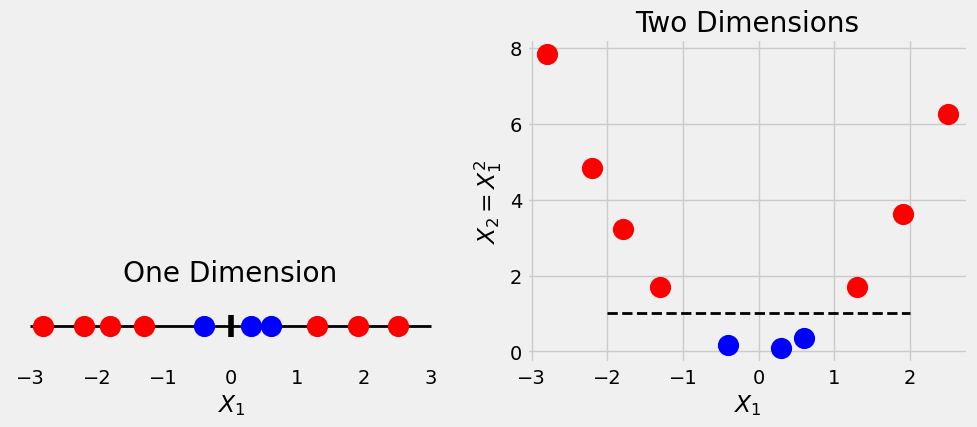

In [11]:
fig = two_dimensions(x, y)

And in Neural Networks may also increase the dimensionality. That's what happens if you add hidden layers with more units/neurons thant the number of features

In [9]:
model = nn.Sequential()
model.add_module('hidden', nn.Linear(2, 10)) # 2D (two features) to 10D
model.add_module('activation', nn.ReLU())   # Computing Logits
model.add_module('output', nn.Linear(10, 1)) # 10D to 1D
model.add_module('sigmoid', nn.Sigmoid())    # Computing Probability

loss_fn = nn.BCELoss()

## Classification Threshold

In [10]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

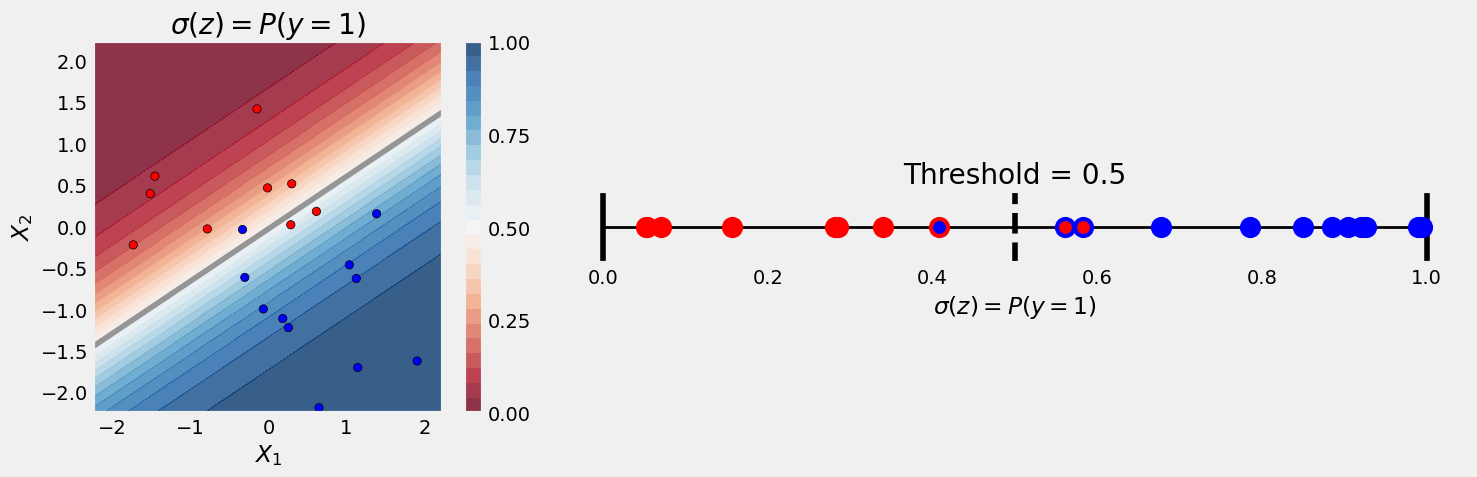

In [10]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold)

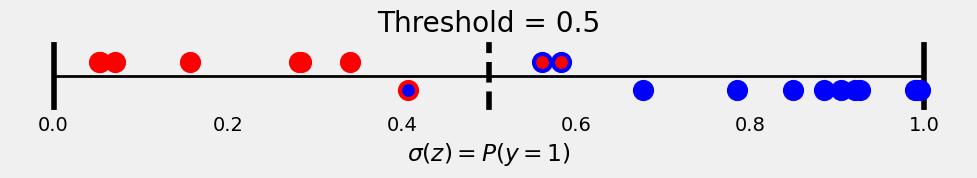

In [11]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, False)

In the image above now all correctly classified and misclassified points are in different quadrants. There is something else that looks exactly like this... The Confusion Matrix

### Confusion Matrix

where those quadrants hava names:

- True Negative (TN)
- False Positive (FP)
- False Negative (FN)
- True Positive (TP)

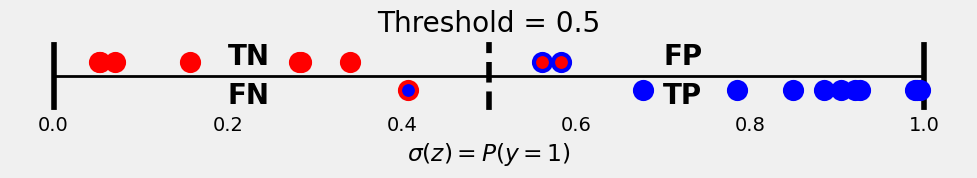

In [12]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

- Points below the line are actual negatives, points below the line are actual positives

- Pointes to the right of the threshold are classified as positive, points to the left of the threshold are classified as negative

In [11]:
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= .5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])

we can see that there are
- 7 TN
- 2 FP
- 1 FN
- 10 TP

NOTE: The Confusion Matrix depends on the Threshold

#### True and False Positives and Negatives

In [12]:
def split_cm(cm):
    # Actual negatives go in the top row,
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row,
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]

    return tn, fp, fn, tp

### Metrics

It's about measuring how good our model is

### True and False Positive Rates

$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

- TPR (True Positive Rate) -> It tells you from all points you know to be positive, how many your model got right
  * From our data our model we got 10 out 11 or roughly 91% then our TPR = 91%

If false negatives are bad for your application, you need to focus on improving the TPR (recall) metric of your model

Example of False Negatives: if positive is an existence of a threat in an airport then a false negative means that the machine failed to detect an actual threat (such as a bomb)

- FPR (False Positive Rate) -> It tells you, from all points you know to be negativem hor many your model got wrong

If false positives are bad for your application, you need to focus on reducing the FPR metric of your model

Example of a False positive: If positive means a profitable investment in a financiang decision. A false positive means that you chose to invest but ended up losing your money

In [13]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    return tpr, fpr

In [16]:
tpr_fpr(cm_thresh50)

(0.9090909090909091, 0.2222222222222222)

### Precision and Recall

Recal is the same as TPR: from all the positive exmples, how many does your model recall?

Precision is about the positive values: From all points classified as positive by your model, how many did it get right?. In our example, the model classified 12 points as positive. The model got 10 right. The precision is 10 out of 12 or roughly 83%

$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

In [14]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return precision, recall

In [15]:
precision_recall(cm_thresh50)

(0.8333333333333334, 0.9090909090909091)

### Accuracy

It's about of how many times your model got it right, considering all data points.

The problem of accuracy is that there is no Trade-off and therfore could be misleading

$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

## Trade-offs and Curves

ROC: Receiver operating characteristics

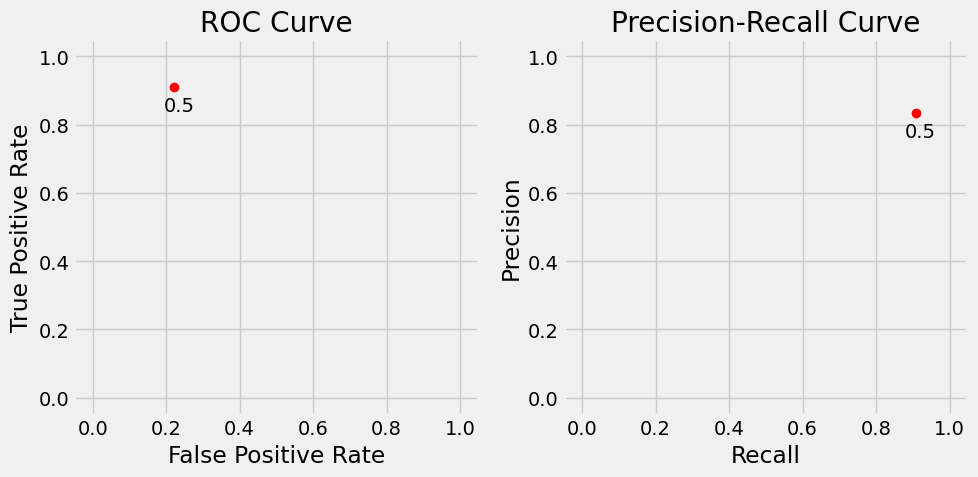

In [16]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.5], annot=True)

### Low Threshold

The model does not need to be very confident

We can expect from a model with a low Threshold as more false positives, fewer false negatives



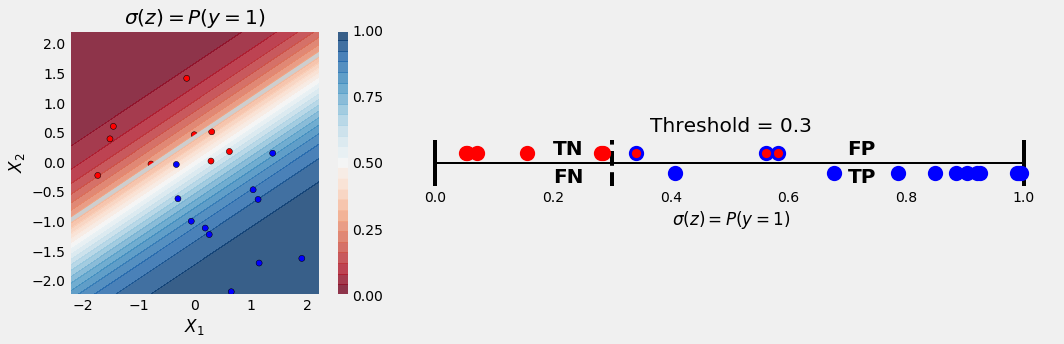

In [ ]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.3, shift=0.04, annot=True)

In [17]:
confusion_matrix(y_val, (probabilities_val >= 0.3))

array([[ 6,  3],
       [ 0, 11]])

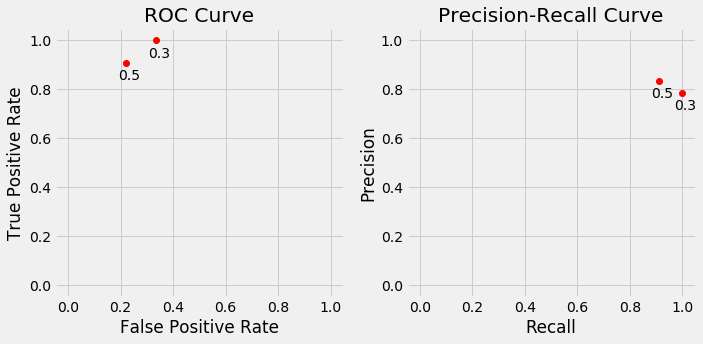

In [ ]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5], annot=True)

### High Threshold

The model need to be so confident as possible.

From the model we can expect fewer false positives, more false negatives

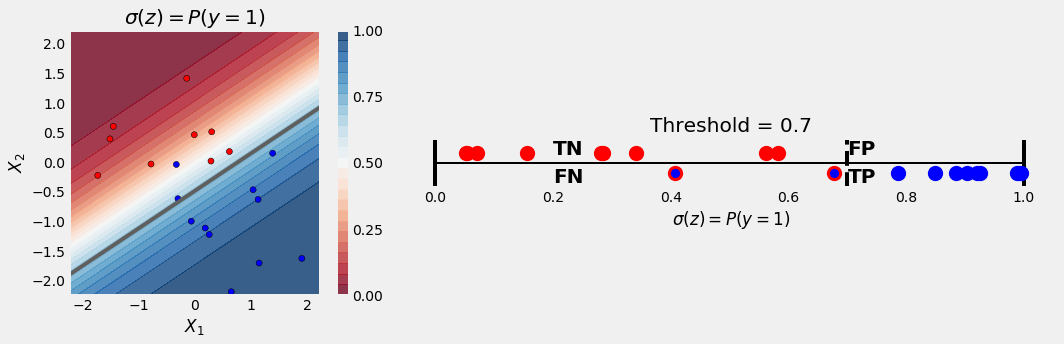

In [ ]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.7, shift=0.04, annot=True)

In [ ]:
confusion_matrix(y_val, (probabilities_val >= 0.7))

array([[9, 0],
       [2, 9]])

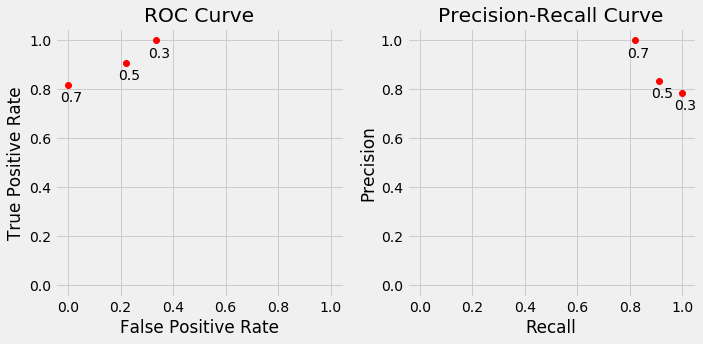

In [ ]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5, .7], annot=True)

### ROC and PR Curves

In [ ]:
threshs = np.linspace(0.,1,11)

/home/dvgodoy/projects/PyTorchStepByStep/plots/chapter3.py:49: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


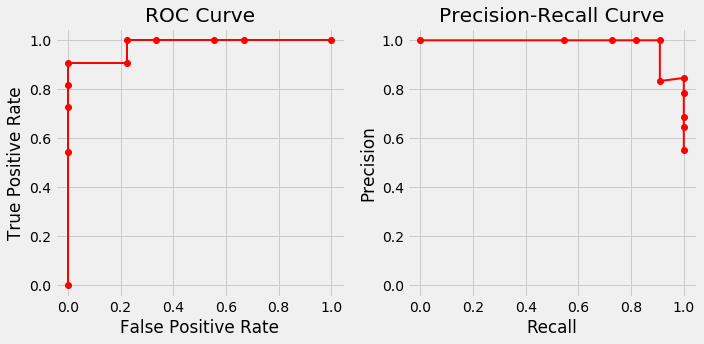

In [ ]:
fig = figure17(y_val, probabilities_val, threshs)

In [ ]:
fpr, tpr, thresholds1 = roc_curve(y_val, probabilities_val)
prec, rec, thresholds2 = precision_recall_curve(y_val, probabilities_val)

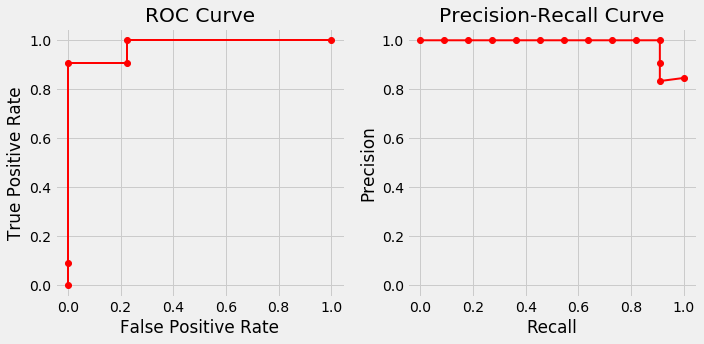

In [ ]:
fig = eval_curves(fpr, tpr, rec, prec, thresholds1, thresholds2, line=True)

### The Precision Quirk

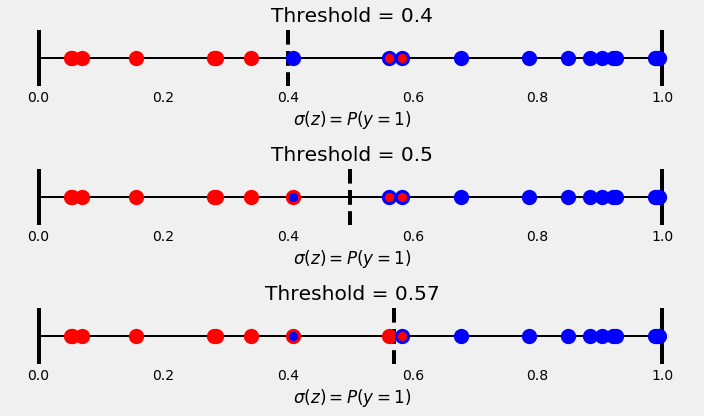

In [ ]:
fig = figure19(y_val, probabilities_val)

$$
\Large \text{Precision}(\text{thresh}=0.40)=\frac{13}{13+2}=0.8666
$$

$$
\Large \text{Precision}(\text{thresh}=0.50)=\frac{(13-1)}{(13-1)+2}=\frac{12}{12+2}=0.8571
$$

$$
\Large \text{Precision}(\text{thresh}=0.57)=\frac{12}{12+(2-1)}=\frac{12}{12+1}=0.9230
$$

### Best and Worst Curves

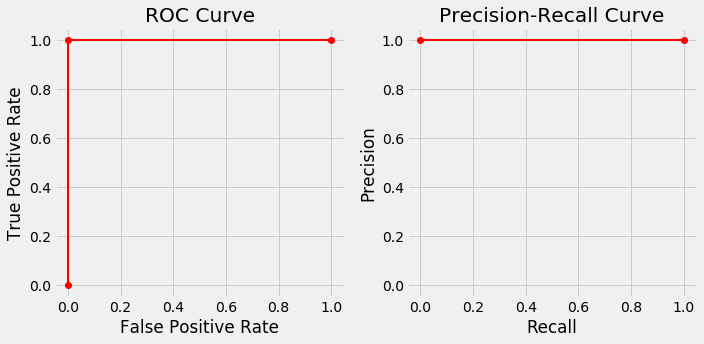

In [ ]:
# Best
fig = figure20(y_val)

In [ ]:
np.random.seed(39)
random_probs = np.random.uniform(size=y_val.shape)

In [ ]:
fpr_random, tpr_random, thresholds1_random = roc_curve(y_val, random_probs)
prec_random, rec_random, thresholds2_random = precision_recall_curve(y_val, random_probs)

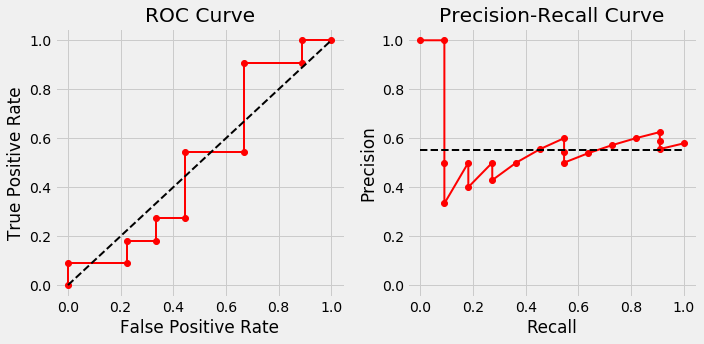

In [ ]:
# Worst
fig = figure21(y_val, random_probs)

### Comparing Models

If I have two models, how do I choose the best one?

The best model is the one with the best curve (square)

In [ ]:
# Area under the curves of our model
auroc = auc(fpr, tpr)
aupr = auc(rec, prec)
print(auroc, aupr)

0.9797979797979798 0.9854312354312356


In [ ]:
# Area under the curves of the random model
auroc_random = auc(fpr_random, tpr_random)
aupr_random = auc(rec_random, prec_random)
print(auroc_random, aupr_random)

0.505050505050505 0.570559046216941


## Putting It All Together

In [18]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [19]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

In [20]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

In [21]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]])), ('linear.bias', tensor([-0.0591]))])


In [22]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])